lstm3

과정 요약:<br> 
feature: season, day of week, week number, sales <br> 
feature engineering: outlier delete + normalize + denormalize

결과요약: RMSE: 0.24234837293624878 

상세과정:
주중(1)/주말(2) + 겨울(1)봄(2)여름(3)가을(4) // 
이미 lstm이라는 것이 sequence 개념이 있으므로 시간축(1~397)를 feature로 설정하는 것은 의미가 없을 듯 하여 LSTM 시도2에서는 제외함

추가의견) 개인적으로 이상점을 제거한 후 normalize를 하면 rmse가 커질 수 밖에 없다고 생각함. 다음시도(lstm3)은 이상점을 제거하지 않고 normalize를 하고, lstm4에서는 이상점을 제거하고 normalize를 하지 않는 것을 시도하겠다.

추가의견2) 처음에는 denormalize과정 없이 rmse를 구했는데, 이것보다는 denormalize를 한 후 rmse를 구하여 모델간 비교를 하는 것이 더 적절한 것 같다. normalize는 어디까지나 변환이니 항상 변환을 할때는 역변환을 하여 원본 데이터 형태m로 생각하는 것이 덜 헷갈리고, 결과값에 대한 더욱 직관적인 이해가 가능할 것 같다. 그리고, 여러 형태의 data transformation이 있는데 normalize 가장 마지막 단계의 data transformation인 것 같다. 다른 로그나 루트 변환을 한 후 normalization을 하고, 그리고 예측값이 모델을 통해 생성되면 바로 denormalize하고...예측(뉴럴) 모델의 input직전과 output직후.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime   

set seednumber(7 or 77)

In [2]:
tf.set_random_seed(77)

# 1. DATA 준비

In [3]:
columns=['date','sales']

txs=pd.read_table('./lstmData/lstmPrac2.csv', sep=',',header=None,names=columns )
txs.info()
txs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
date     397 non-null object
sales    397 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.3+ KB


,date,sales
0,2016-01-01,34
1,2016-01-02,41
2,2016-01-03,54
3,2016-01-04,41
4,2016-01-05,35


In [4]:
sales=list(txs['sales'])

## 1.1 기본 feature

'ds-y'의 ds로부터 api로 얻을 수 있는 값

year, day of week, month, week number를 기본 feature로 설정

In [5]:
year = lambda x: datetime.strptime(x, "%Y-%m-%d" ).year  
day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d" ).weekday()
month = lambda x: datetime.strptime(x, "%Y-%m-%d" ).month
# please read docs on how week numbers are calculate
week_number = lambda x: datetime.strptime(x, "%Y-%m-%d" ).strftime('%V')

In [6]:
txs['year'] = txs['date'].map(year)
txs['month']=txs['date'].map(month)
txs['week_number']=txs['date'].map(week_number)
txs['day_of_week']=txs['date'].map(day_of_week)

## 1.2 추가 feature

'ds-y'의 ds로부터 api로 얻을 수 없는 값: 본 feature를 가공한 feature + ds와 무관한 feature

In [7]:
seasons = [0,0,1,1,1,2,2,2,3,3,3,0] #dec - feb is winter, then spring, summer, fall etc
season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d" ).month-1)]

In [8]:
txs['season']=txs['date'].map(season)
txs

,date,sales,year,month,week_number,day_of_week,season
0,2016-01-01,34,2016,1,53,4,0
1,2016-01-02,41,2016,1,53,5,0
2,2016-01-03,54,2016,1,53,6,0
3,2016-01-04,41,2016,1,01,0,0
4,2016-01-05,35,2016,1,01,1,0
5,2016-01-06,44,2016,1,01,2,0
6,2016-01-07,50,2016,1,01,3,0
7,2016-01-08,42,2016,1,01,4,0
8,2016-01-09,42,2016,1,01,5,0
9,2016-01-10,66,2016,1,01,6,0


pandas를 통해 구한 각 feature는 list()로 우리의 기준type인 list로 변경이 가능

## 1.3 합친 후 normalize하여 최종 data 생성: XY

In [9]:
tempxy=[list(txs['season']),list(txs['day_of_week']),list(txs['week_number']),sales]

In [10]:
XY=np.array(tempxy).transpose().astype(np.float)

In [11]:
XY

array([[  0.,   4.,  53.,  34.],
       [  0.,   5.,  53.,  41.],
       [  0.,   6.,  53.,  54.],
       ..., 
       [  0.,   6.,   4.,   0.],
       [  0.,   0.,   5.,   5.],
       [  0.,   1.,   5.,  31.]])

## 1.3 추가 가공

### 1.3.1 y의 추가 가공

마지막rmse를 계산할 때 원본 데이터를 복원하기 위해 저장해놓음

In [12]:
originalSales=sales

이상점 제거, bucketization 을 하여 새로운 열을 생성하는 방향으로

#### 이상점 제거

이상점 제거를 위해 평균과 표준편차를 구한다. 이상점의 기준은 일단 평균+-2*sd로 설정

In [13]:
mean=np.mean(sales)
std=np.std(sales)
for i in range(len(sales)):
    if (sales[i]<mean-2*std or sales[i]>mean+2*std):
         sales[i]=int(mean)

### 1.3.2 x의 추가 가공

## 1.4 합친 후 normalize하여 최종 data 생성: XY

In [14]:
tempxy=[list(txs['season']),list(txs['day_of_week']),list(txs['week_number']),sales]

In [15]:
xy=np.array(tempxy).transpose().astype(np.float)

In [16]:
xy

array([[  0.,   4.,  53.,  34.],
       [  0.,   5.,  53.,  41.],
       [  0.,   6.,  53.,  54.],
       ..., 
       [  0.,   6.,   4.,   0.],
       [  0.,   0.,   5.,   5.],
       [  0.,   1.,   5.,  31.]])

#### Normalization

In [17]:
def minMaxNormalizer(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/(denominator+1e-7)

마지막rmse를 계산할 때 원본 데이터를 복원하기 위해 저장해놓음

In [18]:
originalSales=sales

Normalization이 필요한 열을 normalize시킴(현재는 sales에 해당하는 마지막 열만 normalize)

In [19]:
xy[:,-1]=minMaxNormalizer(xy[:,-1])

다른 열 ex) XY[:,-3]=minMaxNormalizer(XY[:,-3])

In [20]:
xy

array([[  0.00000000e+00,   4.00000000e+00,   5.30000000e+01,
          3.40000000e-01],
       [  0.00000000e+00,   5.00000000e+00,   5.30000000e+01,
          4.10000000e-01],
       [  0.00000000e+00,   6.00000000e+00,   5.30000000e+01,
          5.39999999e-01],
       ..., 
       [  0.00000000e+00,   6.00000000e+00,   4.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   5.00000000e+00,
          5.00000000e-02],
       [  0.00000000e+00,   1.00000000e+00,   5.00000000e+00,
          3.10000000e-01]])

In [21]:
xy[:,-1]

array([ 0.34,  0.41,  0.54,  0.41,  0.35,  0.44,  0.5 ,  0.42,  0.42,
        0.66,  0.5 ,  0.55,  0.56,  0.53,  0.44,  0.54,  0.54,  0.5 ,
        0.4 ,  0.49,  0.28,  0.72,  0.71,  0.53,  0.43,  0.38,  0.55,
        0.49,  0.43,  0.49,  0.49,  0.44,  0.39,  0.52,  0.45,  0.33,
        0.43,  0.4 ,  0.46,  0.49,  0.5 ,  0.37,  0.37,  0.45,  0.48,
        0.48,  0.38,  0.6 ,  0.31,  0.35,  0.53,  0.7 ,  0.62,  0.48,
        0.51,  0.49,  0.38,  0.32,  0.39,  0.35,  0.3 ,  0.36,  0.31,
        0.31,  0.44,  0.41,  0.41,  0.45,  0.46,  0.45,  0.41,  0.47,
        0.48,  0.4 ,  0.42,  0.38,  0.38,  0.45,  0.48,  0.62,  0.46,
        0.38,  0.62,  0.81,  0.4 ,  0.45,  0.42,  0.53,  0.53,  0.56,
        0.53,  0.47,  0.61,  0.64,  0.62,  0.37,  0.65,  0.54,  0.44,
        0.46,  0.5 ,  0.43,  0.53,  0.63,  0.52,  0.02,  0.  ,  0.  ,
        0.72,  0.59,  0.75,  0.47,  0.44,  0.77,  0.9 ,  0.93,  0.47,
        0.61,  0.77,  0.35,  0.5 ,  0.58,  0.33,  0.41,  0.36,  0.64,
        0.49,  0.53,

#### Denormalization

예측모델을 통해 얻은 sales결과를 denormalize시켜 기존 단위로 변환

In [22]:
def minMaxDeNormalizer(data, originalData):
    shift=np.min(originalData)
    multiplier=np.max(originalData)-np.min(originalData)
    return (data+shift)*multiplier 

이 함수를 마지막 rmse구하기 전에 호출

# 2. MODEL 설계

## 2.1 사용 model 정의: RNN LSTM

## 2.2 해당 model의 train parameters 설정

In [23]:
#data_dim은 y값 도출을 위한 feature 가지수(독립변수 가지수 +1(y포함))
data_dim=4

#data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
seq_length=5

#output_dim(=forecastDays)만큼의 다음날 y_data를 예측
forecastDays=1
output_dim=forecastDays

#hidden_dim은 정말 임의로 설정
hidden_dim=10

#learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
learning_rate=0.01

#iterations는 반복 횟수
iterations=1000

## 2.3 사용 model, train parameter에 맞추어 dataset(XY) 변환: dataX, dataY

In [24]:
x=xy
y=xy[:,[-1]]

#build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length):
    _x=x[i:i+seq_length]
    _y=y[i+seq_length]
    #     _y=Y[i+seq_length:i+seq_length+forecastDays]
    print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)

[[  0.     4.    53.     0.34]
 [  0.     5.    53.     0.41]
 [  0.     6.    53.     0.54]
 [  0.     0.     1.     0.41]
 [  0.     1.     1.     0.35]] -> [ 0.44]
[[  0.     5.    53.     0.41]
 [  0.     6.    53.     0.54]
 [  0.     0.     1.     0.41]
 [  0.     1.     1.     0.35]
 [  0.     2.     1.     0.44]] -> [ 0.5]
[[  0.     6.    53.     0.54]
 [  0.     0.     1.     0.41]
 [  0.     1.     1.     0.35]
 [  0.     2.     1.     0.44]
 [  0.     3.     1.     0.5 ]] -> [ 0.42]
[[ 0.    0.    1.    0.41]
 [ 0.    1.    1.    0.35]
 [ 0.    2.    1.    0.44]
 [ 0.    3.    1.    0.5 ]
 [ 0.    4.    1.    0.42]] -> [ 0.42]
[[ 0.    1.    1.    0.35]
 [ 0.    2.    1.    0.44]
 [ 0.    3.    1.    0.5 ]
 [ 0.    4.    1.    0.42]
 [ 0.    5.    1.    0.42]] -> [ 0.66]
[[ 0.    2.    1.    0.44]
 [ 0.    3.    1.    0.5 ]
 [ 0.    4.    1.    0.42]
 [ 0.    5.    1.    0.42]
 [ 0.    6.    1.    0.66]] -> [ 0.5]
[[ 0.    3.    1.    0.5 ]
 [ 0.    4.    1.    0.42]
 [ 0. 

## 2.4 train/test split

In [25]:
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])

## 2.5 input place holders

X의 경우 input type과 [batch size, sequence length, input data dimension(feature+1))]

Y의 경우 input type과 [batch size, 원하는 output 의 개수(forecastDays)]

In [26]:
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, forecastDays])

## 2.6 build LSTM network model

lstm network의 

    기본단위 cell, 
    
    사용 driver, 
    
    예측 y 산출방식, 
    
    loss 함수, 
    
    사용 optimizer 정하기

### lstm의 한 기본단위인 cell을 생성

cell의 결과값을 fully connected layer로 한 번 더 가공할 것이기 때문에 cell의 output dimension인 num_units=hidden_dim로 설정

In [27]:
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)

### Dynamic rnn이라는 driver를 가동

tf.dynamic_rnn의 input은 cell, input, input type

tf.dynamic_rnn의 output은 outputs와 states

In [28]:
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### 마지막 cell의 output을 이용하여 Y_pred 도출

outputs[:, -1]: cell의 outputs 중 마지막 하나만 이용(we use the last cell's output)

output_dim: fully connected의 최종출력개수는 output_dim(=forecastDays) 

activation_fn= None: 분류 문제가 아니라 회귀 문제이므로 activation_fn은 none

In [29]:
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn= None) 

### loss 정의

In [30]:
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares

### optimizer정의

In [31]:
optimizer = tf.train.AdamOptimizer(learning_rate)

### loss를 줄이는 방향으로 train

In [32]:
train = optimizer.minimize(loss)

# 3. Model 평가 with RMSE

In [33]:
denormalizedTestY=originalSales[train_size+seq_length:]
denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])

In [34]:
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

In [35]:
def rootMeanSquaredError(a,b):
    sum=0
    for i in range(len(a)):
        sum=sum+(a[i]-b[i])**2
    return np.sqrt( sum/len(a))

## 2.5 Train and Test

[step: 0] loss: 61.159820556640625
[step: 1] loss: 16.39006805419922
[step: 2] loss: 13.055374145507812
[step: 3] loss: 17.95273208618164
[step: 4] loss: 16.769330978393555
[step: 5] loss: 13.101293563842773
[step: 6] loss: 9.802703857421875
[step: 7] loss: 7.84617280960083
[step: 8] loss: 7.198201656341553
[step: 9] loss: 7.4416093826293945
[step: 10] loss: 8.067333221435547
[step: 11] loss: 8.64244270324707
[step: 12] loss: 8.910738945007324
[step: 13] loss: 8.808085441589355
[step: 14] loss: 8.409947395324707
[step: 15] loss: 7.856630802154541
[step: 16] loss: 7.2908935546875
[step: 17] loss: 6.820185661315918
[step: 18] loss: 6.5014824867248535
[step: 19] loss: 6.342205047607422
[step: 20] loss: 6.311091423034668
[step: 21] loss: 6.354420185089111
[step: 22] loss: 6.4136271476745605
[step: 23] loss: 6.4406538009643555
[step: 24] loss: 6.408166885375977
[step: 25] loss: 6.313457489013672
[step: 26] loss: 6.175878047943115
[step: 27] loss: 6.028083324432373
[step: 28] loss: 5.9034166

[step: 238] loss: 3.864800214767456
[step: 239] loss: 3.8600833415985107
[step: 240] loss: 3.855410575866699
[step: 241] loss: 3.8507838249206543
[step: 242] loss: 3.846205711364746
[step: 243] loss: 3.841677188873291
[step: 244] loss: 3.837198495864868
[step: 245] loss: 3.8327693939208984
[step: 246] loss: 3.8283896446228027
[step: 247] loss: 3.8240559101104736
[step: 248] loss: 3.8197686672210693
[step: 249] loss: 3.8155219554901123
[step: 250] loss: 3.811314105987549
[step: 251] loss: 3.807140588760376
[step: 252] loss: 3.802999973297119
[step: 253] loss: 3.7988860607147217
[step: 254] loss: 3.7947959899902344
[step: 255] loss: 3.7907261848449707
[step: 256] loss: 3.7866709232330322
[step: 257] loss: 3.7826266288757324
[step: 258] loss: 3.7785887718200684
[step: 259] loss: 3.7745532989501953
[step: 260] loss: 3.770515203475952
[step: 261] loss: 3.7664716243743896
[step: 262] loss: 3.7624189853668213
[step: 263] loss: 3.758356809616089
[step: 264] loss: 3.7542834281921387
[step: 265]

[step: 471] loss: 2.9734137058258057
[step: 472] loss: 2.970568895339966
[step: 473] loss: 2.9677891731262207
[step: 474] loss: 2.9651412963867188
[step: 475] loss: 2.9626970291137695
[step: 476] loss: 2.96063232421875
[step: 477] loss: 2.9589943885803223
[step: 478] loss: 2.9578988552093506
[step: 479] loss: 2.956650972366333
[step: 480] loss: 2.9547312259674072
[step: 481] loss: 2.9505624771118164
[step: 482] loss: 2.9447145462036133
[step: 483] loss: 2.939028739929199
[step: 484] loss: 2.9355528354644775
[step: 485] loss: 2.934044122695923
[step: 486] loss: 2.9328458309173584
[step: 487] loss: 2.930426597595215
[step: 488] loss: 2.926146984100342
[step: 489] loss: 2.9215168952941895
[step: 490] loss: 2.9180068969726562
[step: 491] loss: 2.9157559871673584
[step: 492] loss: 2.913832664489746
[step: 493] loss: 2.9111294746398926
[step: 494] loss: 2.907439708709717
[step: 495] loss: 2.903473138809204
[step: 496] loss: 2.900141716003418
[step: 497] loss: 2.897507667541504
[step: 498] lo

[step: 703] loss: 2.3587071895599365
[step: 704] loss: 2.339970588684082
[step: 705] loss: 2.3426826000213623
[step: 706] loss: 2.356778383255005
[step: 707] loss: 2.362121343612671
[step: 708] loss: 2.351215124130249
[step: 709] loss: 2.3348138332366943
[step: 710] loss: 2.329608678817749
[step: 711] loss: 2.3363089561462402
[step: 712] loss: 2.3421223163604736
[step: 713] loss: 2.3378636837005615
[step: 714] loss: 2.3270556926727295
[step: 715] loss: 2.320869207382202
[step: 716] loss: 2.322903871536255
[step: 717] loss: 2.326780319213867
[step: 718] loss: 2.3255960941314697
[step: 719] loss: 2.3190488815307617
[step: 720] loss: 2.3131065368652344
[step: 721] loss: 2.3118743896484375
[step: 722] loss: 2.3136377334594727
[step: 723] loss: 2.314094305038452
[step: 724] loss: 2.311000347137451
[step: 725] loss: 2.306217670440674
[step: 726] loss: 2.302868366241455
[step: 727] loss: 2.302079677581787
[step: 728] loss: 2.302405595779419
[step: 729] loss: 2.3017947673797607
[step: 730] los

[step: 940] loss: 2.003368377685547
[step: 941] loss: 2.0073540210723877
[step: 942] loss: 2.009110450744629
[step: 943] loss: 2.0064432621002197
[step: 944] loss: 2.0012569427490234
[step: 945] loss: 1.9972059726715088
[step: 946] loss: 1.9963213205337524
[step: 947] loss: 1.9977364540100098
[step: 948] loss: 1.9990214109420776
[step: 949] loss: 1.9983775615692139
[step: 950] loss: 1.995829701423645
[step: 951] loss: 1.9927730560302734
[step: 952] loss: 1.9906926155090332
[step: 953] loss: 1.9900928735733032
[step: 954] loss: 1.9903992414474487
[step: 955] loss: 1.990588903427124
[step: 956] loss: 1.9899489879608154
[step: 957] loss: 1.9884365797042847
[step: 958] loss: 1.9865331649780273
[step: 959] loss: 1.9848442077636719
[step: 960] loss: 1.9837262630462646
[step: 961] loss: 1.9831565618515015
[step: 962] loss: 1.9828497171401978
[step: 963] loss: 1.9824659824371338
[step: 964] loss: 1.9817872047424316
[step: 965] loss: 1.9807754755020142
[step: 966] loss: 1.9795509576797485
[step

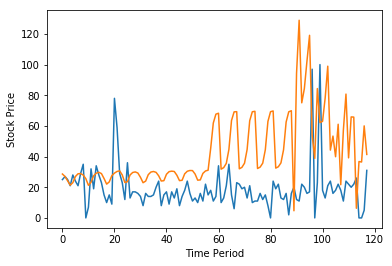

In [36]:
with tf.Session() as sess:
    #초기화
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalSales)
    rmse_val = sess.run(rmse, feed_dict={targets: denormalizedTestY_feed, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(denormalizedTestY_feed)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

In [37]:
denormalizedTestPredictY=[item for sublist in test_predict for item in sublist]

In [38]:
rootMeanSquaredError(denormalizedTestY,denormalizedTestPredictY)

35.470242788206967